In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
from scipy.signal import cont2discrete, lti, dlti, dstep
from scipy import linalg
from scipy.integrate import odeint

In [3]:
def EGIG_inf(M,Mstar):
    A, H, Q, R = M
    Astar, Hstar, Qstar, Rstar = Mstar
    dimx = np.shape(A)[0]
    dimy = np.shape(H)[0]
    # Sig_L, Sig_D
    # Sig_L : Solution to the lyapunov equation Sig_L = A*Sig_L*A'+Q
    Sig_L = linalg.solve_discrete_lyapunov(A, Q, method=None)
    Sig_L_inv = np.linalg.solve(Sig_L, np.eye(dimx))
    Sig_Lstar = linalg.solve_discrete_lyapunov(Astar, Qstar, method=None)
    # Sig_D : First solve for Gamma
    # scipy.linalg.solve_discrete_are(a, b, q, r, e=None, s=None, balanced=True)
    # A'*X*A + Q - X -(A'XB)(R+B'XB)^{-1}(B'XA)
    Gamma =  linalg.solve_discrete_are(np.transpose(A), np.transpose(H), Q, R, e=None, s=None, balanced=True)
    #Γ = AΓAt + Q − AΓHT (HΓHT + R)−1HΓAT
    Sig_D_p1 = np.matmul(Gamma,np.transpose(H)) 
    Sig_D_p2inv = np.add(np.matmul(H,np.matmul(Gamma,np.transpose(H))),R)
    if len(Sig_D_p2inv)==1:
        Sig_D_p2 = 1/Sig_D_p2inv
    else:
        #TAC CHANGE
        Sig_D_p2 = np.linalg.solve(Sig_D_p2inv,np.eye(dimy))
    Sig_D_p3 = np.matmul(H,Gamma)
    Sig_D = np.subtract(Gamma,np.matmul(np.matmul(Sig_D_p1,Sig_D_p2),Sig_D_p3))
    Sig_D_inv = np.linalg.solve(Sig_D,np.eye(dimx))
    # Gamma - Gamma*H'(H*Gamma*H'+R)^{-1}H*Gamma
    Gammastar =  linalg.solve_discrete_are(np.transpose(Astar), np.transpose(Hstar), Qstar, Rstar, e=None, s=None, balanced=True)
    #Γ = AΓAt + Q − AΓHT (HΓHT + R)−1HΓAT
    Sig_D_p1star = np.matmul(Gammastar,np.transpose(Hstar)) 
    Sig_D_p2invstar = np.add(np.matmul(Hstar,np.matmul(Gammastar,np.transpose(Hstar))),Rstar)
    if len(Sig_D_p2invstar)==1:
        Sig_D_p2star = 1/Sig_D_p2invstar
    else:
        #TAC CHANGE
        Sig_D_p2star = np.linalg.solve(Sig_D_p2invstar,np.eye(dimy))
    Sig_D_p3star = np.matmul(Hstar,Gammastar)
    Sig_Dstar = np.subtract(Gammastar,np.matmul(np.matmul(Sig_D_p1star,Sig_D_p2star),Sig_D_p3star))
    # Gamma - Gamma*H'(H*Gamma*H'+R)^{-1}H*Gamma
    # Calculating Mdelta
    # Abig = [[(I-KH)A KHstar*Astar],[0 Astar]]
    
    S = jnp.add(jnp.matmul(H,jnp.matmul(Gamma,jnp.transpose(H))),R)
    Sstar = jnp.add(jnp.matmul(Hstar,jnp.matmul(Gammastar,jnp.transpose(Hstar))),Rstar)
    S_inv = jnp.linalg.solve(S,jnp.identity(dimy))
    Sstar_inv = jnp.linalg.solve(Sstar,jnp.identity(dimy))
    K = jnp.matmul(Gamma,jnp.matmul(jnp.transpose(H),S_inv))
    Kstar = jnp.matmul(Gammastar,jnp.matmul(jnp.transpose(Hstar),Sstar_inv))
    a11 = np.matmul(np.subtract(np.eye(dimx),np.matmul(K,H)),A)
    a12 = np.matmul(K,np.matmul(Hstar,Astar))
    
    ######TAC Change
    #a21 = np.eye(dimx)
    a21 = np.zeros((dimx,dimx))
    
    a22 = Astar
    A1 = np.concatenate((a11,a12),axis=1)
    A2 = np.concatenate((a21,a22),axis=1)
    Asys = np.concatenate((A1,A2),axis=0)
    
    q11 = np.matmul(K,np.matmul(Sstar,np.transpose(K)))
    q12 = np.matmul(K,np.matmul(Sstar,np.transpose(Kstar)))
    q21 = np.matmul(Kstar,np.matmul(Sstar,np.transpose(K)))
    q22 = np.matmul(Kstar,np.matmul(Sstar,np.transpose(Kstar)))
    Q1 = np.concatenate((q11,q12),axis=1)
    Q2 = np.concatenate((q21,q22),axis=1)
    Qsys = np.concatenate((Q1,Q2),axis=0)
    Msys = linalg.solve_discrete_lyapunov(Asys, Qsys, method=None)
    maskmat = np.concatenate((-1*np.eye(dimx),np.eye(dimx)),axis=1)#np.transpose(np.array([[-1*np.eye(dimx)],[np.eye(dimx)]]))
    Mdel = np.matmul(maskmat,np.matmul(Msys,np.transpose(maskmat)))
    sl,ldl = jnp.linalg.slogdet(Sig_L)
    sd,ldd = jnp.linalg.slogdet(Sig_D)

    T1 = 0.5*np.trace(np.matmul(Sig_L_inv,Sig_Lstar))
    T2 = -0.5*np.trace(np.matmul(Sig_D_inv,np.add(Sig_Dstar,Mdel)))
    T3 = 0.5*(ldl-ldd)
    EGIG = T1+T2+T3
    return EGIG


def EIG_inf(M):
    A, H, Q, R = M
    dimx = np.shape(A)[0]
    dimy = np.shape(H)[0]
    # Sig_L, Sig_D
    # Sig_L : Solution to the lyapunov equation Sig_L = A*Sig_L*A'+Q
    Sig_L = linalg.solve_discrete_lyapunov(A, Q, method=None)
    Gamma =  linalg.solve_discrete_are(np.transpose(A), np.transpose(H), Q, R, e=None, s=None, balanced=True)
    #Γ = AΓAt + Q − AΓHT (HΓHT + R)−1HΓAT
    Sig_D_p1 = np.matmul(Gamma,np.transpose(H)) 
    Sig_D_p2inv = np.add(np.matmul(H,np.matmul(Gamma,np.transpose(H))),R)
    if len(Sig_D_p2inv)==1:
        Sig_D_p2 = 1/Sig_D_p2inv
    else:
        #TAC CHANGE
        Sig_D_p2 = np.linalg.solve(Sig_D_p2inv,np.eye(dimy))
    Sig_D_p3 = np.matmul(H,Gamma)
    Sig_D = np.subtract(Gamma,np.matmul(np.matmul(Sig_D_p1,Sig_D_p2),Sig_D_p3))
    sl,ldl = jnp.linalg.slogdet(Sig_L)
    sd,ldd = jnp.linalg.slogdet(Sig_D)
    EIG = 0.5*(ldl-ldd)
    return EIG

# def EDI_inf():





In [4]:
# Spring Mass Damper System as State Space Model, with stochastoc forcing
m = 1   # Mass
k = 1   # Spring Constant
b = 0.2 # Damping Constant
# F : Input force

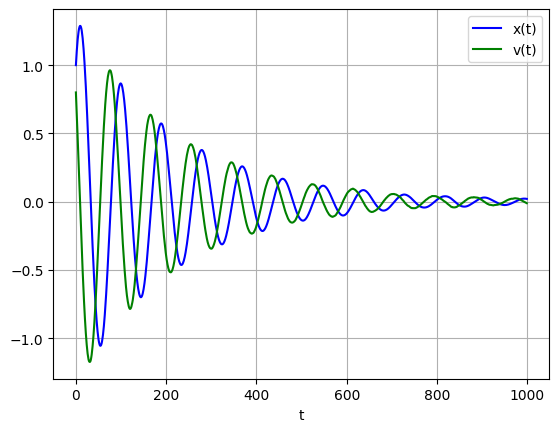

In [5]:
# Simulate System and output (x,y) pair
# Initial conditions
x0 = np.array([1.0,0.80]).reshape((2,1))  # initial displacement and velocity
x = x0
# Time vector
n = 1000  # start, stop, number of samples
T = 0.07
A = np.array([[1, T],[-k*T/m, (-b*T/m)+1]])
B = np.array([0,T/m]).reshape((2,1))
C = np.array([1, 0]).reshape((1,2))
D = [0]
q = 0.01
Q = np.inner(B,q*q*B)
F = np.random.normal(loc=0.0, scale=q, size=n)
for i in range(n-1):
    s1 = np.matmul(A,x0)
    s2 = F[i]*B
    x0 = np.add(s1,s2)
    x  = np.hstack((x,x0))

import matplotlib.pyplot as plt
plt.plot(x[0, :], 'b', label='x(t)')
plt.plot(x[1, :], 'g', label='v(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()
# print(F.shape)

In [6]:
# The SMDS is stable and the states all go to zero. Using this assumption we calculate the EGIG_inf
rsig = 0.6
#Delta = #np.array([0.0,0.0]).reshape((1,2))
#Delta = np.zeros((1,2))
Delta = np.array([[0.0,0.0],[0.0,0.0]])
R = np.array([rsig*rsig]) 
M = A, C, Q, R
Mstar = A+Delta, C, Q, R
egig_infval = EGIG_inf(M,Mstar)
eig_infval = EIG_inf(M)
print(egig_infval)
print(eig_infval)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


0.00410498720631125
0.00410498720631125


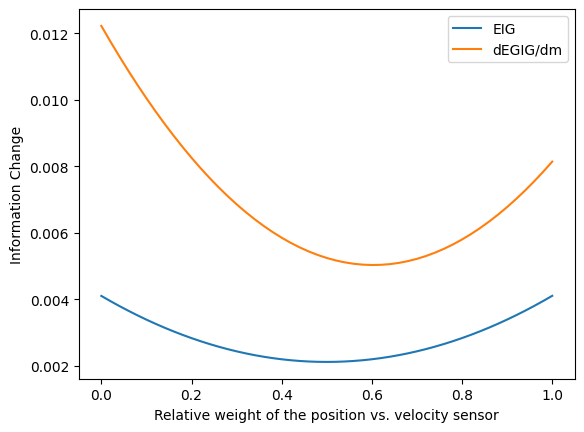

In [7]:
#compute sensitivity to changes in the mass
nstep = 51
ds = np.linspace(0,1,nstep)
infodat = np.zeros((nstep,2))
for inc in range(0,nstep):
    A = np.array([[1, T],[-k*T/m, (-b*T/m)+1]])
    B = np.array([0,T/m]).reshape((2,1))
    C = np.array([1.0-ds[inc], ds[inc]]).reshape((1,2))
    D = [0]
    q = 0.01
    Q = np.inner(B,q*q*B)
    
    rsig = 0.6
    Delta = np.array([[0.0,0.0],[0.0,0.0]])
    R = np.array([rsig*rsig]) 
    M = A, C, Q, R
    Mstar = A+Delta, C, Q, R
    egig_infval = EGIG_inf(M,Mstar)
    eig_infval = EIG_inf(M)

    eig_infval = EIG_inf(M)

    pert = 0.0001
    mpert = m+pert
    Astar = np.array([[1, T],[-k*T/mpert, (-b*T/mpert)+1]])
    Bstar = np.array([0,T/mpert]).reshape((2,1))
    Qstar = np.inner(B,q*q*B)
    Mstar_plus = Astar, C, Qstar, R
    egig_infval_plus = EGIG_inf(M,Mstar_plus)


    mpert = m-pert
    Astar = np.array([[1, T],[-k*T/mpert, (-b*T/mpert)+1]])
    Bstar = np.array([0,T/mpert]).reshape((2,1))
    Qstar = np.inner(B,q*q*B)
    Mstar_min = Astar, C, Qstar, R

    egig_infval_min = EGIG_inf(M,Mstar_min)

    infodat[inc,0] = eig_infval
    infodat[inc,1] = (egig_infval_plus - egig_infval_min)/(2*pert)

infodatm = infodat

plt.plot(ds, infodat[:,0])
plt.plot(ds, infodat[:,1])
plt.legend(['EIG','dEGIG/dm'])
plt.xlabel('Relative weight of the position vs. velocity sensor')
plt.ylabel('Information Change')
plt.show()

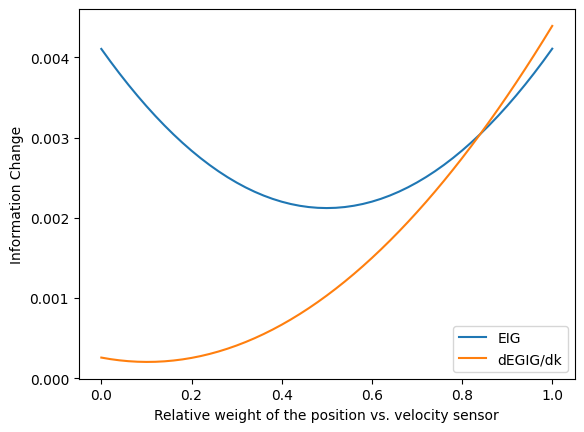

In [8]:
#compute sensitivity to changes in the k
nstep = 51
ds = np.linspace(0,1,nstep)
infodat = np.zeros((nstep,2))
for inc in range(0,nstep):
    A = np.array([[1, T],[-k*T/m, (-b*T/m)+1]])
    B = np.array([0,T/m]).reshape((2,1))
    C = np.array([1.0-ds[inc], ds[inc]]).reshape((1,2))
    D = [0]
    q = 0.01
    Q = np.inner(B,q*q*B)
    
    rsig = 0.6
    Delta = np.array([[0.0,0.0],[0.0,0.0]])
    R = np.array([rsig*rsig]) 
    M = A, C, Q, R
    Mstar = A+Delta, C, Q, R
    egig_infval = EGIG_inf(M,Mstar)
    eig_infval = EIG_inf(M)

    eig_infval = EIG_inf(M)

    pert = 0.0001
    mpert = m
    kpert = k+pert
    Astar = np.array([[1, T],[-kpert*T/mpert, (-b*T/mpert)+1]])
    Bstar = np.array([0,T/mpert]).reshape((2,1))
    Qstar = np.inner(B,q*q*B)
    Mstar_plus = Astar, C, Qstar, R
    egig_infval_plus = EGIG_inf(M,Mstar_plus)


    kpert = k-pert
    mpert = m
    Astar = np.array([[1, T],[-kpert*T/mpert, (-b*T/mpert)+1]])
    Bstar = np.array([0,T/mpert]).reshape((2,1))
    Qstar = np.inner(B,q*q*B)
    Mstar_min = Astar, C, Qstar, R

    egig_infval_min = EGIG_inf(M,Mstar_min)

    infodat[inc,0] = eig_infval
    infodat[inc,1] = (egig_infval_plus - egig_infval_min)/(2*pert)

infodatk = infodat

plt.plot(ds, infodat[:,0])
plt.plot(ds, infodat[:,1])
plt.legend(['EIG','dEGIG/dk'])
plt.xlabel('Relative weight of the position vs. velocity sensor')
plt.ylabel('Information Change')
plt.show()

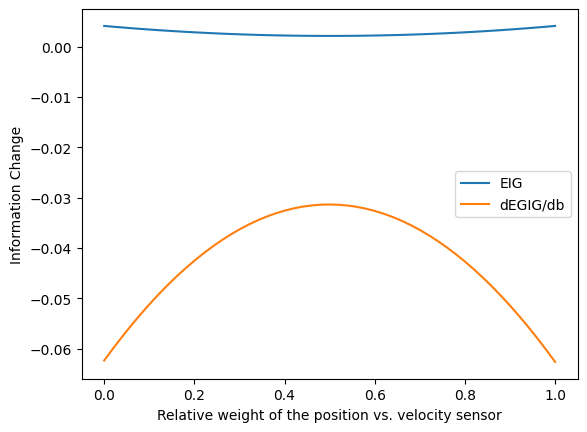

In [9]:
#compute sensitivity to changes in the k
nstep = 51
ds = np.linspace(0,1,nstep)
infodat = np.zeros((nstep,2))
for inc in range(0,nstep):
    A = np.array([[1, T],[-k*T/m, (-b*T/m)+1]])
    B = np.array([0,T/m]).reshape((2,1))
    C = np.array([1.0-ds[inc], ds[inc]]).reshape((1,2))
    D = [0]
    q = 0.01
    Q = np.inner(B,q*q*B)
    
    rsig = 0.6
    Delta = np.array([[0.0,0.0],[0.0,0.0]])
    R = np.array([rsig*rsig]) 
    M = A, C, Q, R
    Mstar = A+Delta, C, Q, R
    egig_infval = EGIG_inf(M,Mstar)
    eig_infval = EIG_inf(M)

    eig_infval = EIG_inf(M)

    pert = 0.0001
    mpert = m
    kpert = k
    bpert = b + pert
    Astar = np.array([[1, T],[-kpert*T/mpert, (-bpert*T/mpert)+1]])
    Bstar = np.array([0,T/mpert]).reshape((2,1))
    Qstar = np.inner(B,q*q*B)
    Mstar_plus = Astar, C, Qstar, R
    egig_infval_plus = EGIG_inf(M,Mstar_plus)

    bpert = b - pert
    kpert = k
    mpert = m
    Astar = np.array([[1, T],[-kpert*T/mpert, (-bpert*T/mpert)+1]])
    Bstar = np.array([0,T/mpert]).reshape((2,1))
    Qstar = np.inner(B,q*q*B)
    Mstar_min = Astar, C, Qstar, R

    egig_infval_min = EGIG_inf(M,Mstar_min)

    infodat[inc,0] = eig_infval
    infodat[inc,1] = (egig_infval_plus - egig_infval_min)/(2*pert)

infodatb = infodat

plt.plot(ds, infodat[:,0])
plt.plot(ds, infodat[:,1])
plt.legend(['EIG','dEGIG/db'])
plt.xlabel('Relative weight of the position vs. velocity sensor')
plt.ylabel('Information Change')
plt.show()

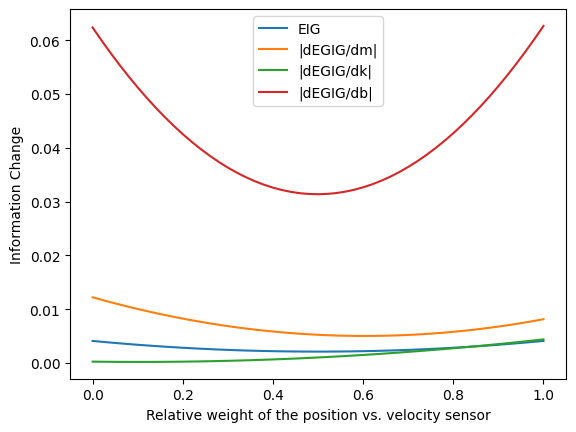

In [10]:
plt.plot(ds, infodatm[:,0])
plt.plot(ds, infodatm[:,1])
plt.plot(ds, infodatk[:,1])
plt.plot(ds, np.abs(infodatb[:,1]))
plt.legend(['EIG','|dEGIG/dm|','|dEGIG/dk|','|dEGIG/db|'])
plt.xlabel('Relative weight of the position vs. velocity sensor')
plt.ylabel('Information Change')
plt.show()

In [11]:
# EGIG Calculation 
Delta = np.array([0.1,0.01]).reshape((1,2))
# Delta_egig = np.array([0.1,0.01]).reshape((1,2))
# Delta_eig = jnp.zeros((1,2))
egig_del_val = np.zeros(n-1)
eig_del_val = np.zeros(n-1)
eig_val = np.zeros(n-1)
etil_del = np.zeros(n-1)


# Kalman filter algorithm
x0 = np.zeros((2,1))  
mu = x0  # initial state estimate
# Make sure this one is zero for the asymptotic case metric calculations
P = P0  # initial covariance estimate
mu_prior = mu
P_prior = P
# mu_prior_Cdel = mu
# P_prior_Cdel = P
mu_post_Cdel = mu
P_post_Cdel = P
mu_post_C = mu
P_post_C = P
Cdel = np.add(C,Delta)


x_kf = x0
x_kf_Cdel = x0
x_kf_C = x0

for i in range(n-1):
    # EGIG with Delta.
    # The reference posterior distribution is with the correct C
    # The calculated posterior distribution is with the  C + Delta
    # The prior distribution is just the update with no C

    # prior distribution
    mu_prior = np.matmul(A,mu_prior)  # predict the next state
    P_prior = np.add(np.matmul(A,np.matmul(P_prior,np.transpose(A))), Q)  # predict the next covariance
    x_kf  = np.hstack((x_kf,mu_post_Cdel))

    # posterior distribution with C + Delta
    # Predict step
    mu_pred_Cdel = np.matmul(A,mu_post_Cdel)  # predict the next state
    P_pred_Cdel = np.add(np.matmul(A,np.matmul(P_post_Cdel,np.transpose(A))), Q)  # predict the next covariance
    # Update step
    y_pred_Cdel = np.matmul(Cdel,mu_pred_Cdel)  # predict the measurement
    S_Cdel = np.add(np.matmul(Cdel,np.matmul(P_pred_Cdel,np.transpose(Cdel))),R)
    K_Cdel = np.matmul(np.matmul(P_pred_Cdel,np.transpose(Cdel)),(1/S_Cdel)) # calculate the Kalman gain
    res_Cdel = np.subtract(y[i],y_pred_Cdel)
    mu_post_Cdel  = np.add(mu_pred_Cdel,np.matmul(K_Cdel,res_Cdel))  # update the state estimate
    P_post_Cdel  = np.matmul(np.subtract(np.eye(2),np.matmul(K_Cdel,Cdel)),P_pred_Cdel)  # update the covariance estimate
    x_kf_Cdel  = np.hstack((x_kf_Cdel,mu_post_Cdel))
    
    # posterior distribution with C
    # Predict step
    mu_pred_C = np.matmul(A,mu_post_C)  # predict the next state
    P_pred_C = np.add(np.matmul(A,np.matmul(P_post_C,np.transpose(A))), Q)  # predict the next covariance
    # Update step
    y_pred_C = np.matmul(C,mu_pred_C)  # predict the measurement
    S_C = np.add(np.matmul(C,np.matmul(P_pred_C,np.transpose(C))),R)
    K_C = np.matmul(np.matmul(P_pred_C,np.transpose(C)),(1/S_C)) # calculate the Kalman gain
    res_C = np.subtract(y[i],y_pred_C)
    mu_post_C  = np.add(mu_pred_C,np.matmul(K_C,res_C))  # update the state estimate
    P_post_C  = np.matmul(np.subtract(np.eye(2),np.matmul(K_C,C)),P_pred_C)  # update the covariance estimate
    x_kf_C  = np.hstack((x_kf_C,mu_post_C))

    # Need to careful here
    # The C+Delta system evolves seperately than C system
    egig_del_val[i] = EGIG_delta_inf(P_pred_Cdel,P_pred_C, P_prior, C, Delta, R)


    # eig_del_val[i] = EGIG(P_pred_Cdel, C, Delta, R)
    # egig_del_val[i] = EGIG(P_prior, C, Delta_egig, R)



    # egig_del_val[i] = EGIG(P_pred, C, Delta_egig, R)
    # eig_val[i] = EGIG(P_pred, C, Delta_eig, R)
    # etil_del[i] = ETIL_Delta(P_pred, H, Delta, R)
    # print(f"Time step {i}: x = {mu.ravel()}")

NameError: name 'P0' is not defined

In [ ]:
plt.plot(egig_del_val)
# plt.plot(eig_del_val)
# plt.plot(eig_val)
# plt.legend(['egig','eig del','eig'])
# print(egig_del_val)

In [12]:
# !pip install slycot   # optional
# !pip install control

# Pull out longitudinal dynamics -- states:(theta,V,alpha,q), control:(T,ele)
longA = np.array([[0.0,0.0,0.0,1.0],
                  [-32.17,-0.0118591,-2.58453,-1.28295],
                  [-3.88959e-9,-0.000255941,-0.782055,0.929171],
                  [0.0,-8.61454e-10,-0.455764,-1.01533]])

longB = np.array([[0.0,0.0],
                  [0.00156727,0.0662367],
                  [-1.8526e-7,-0.00172694],
                  [0.0,-0.140354]])  

# After LQG controller design, the closed loop A is
Acl = np.array([[0.0,0.0,0.0,1.0],
               [-31.0566,-0.0265269,-2.66791,-0.659544],
               [-0.0288024,0.000119201,-0.77989,0.913012],
               [-2.34078,0.0304863,-0.279759,-2.32854]])

A = Acl
B = np.zeros((4,1))
C = np.eye(4)
D = np.zeros((4,1))
l_system = lti(A, B, C, D)

# method in ['zoh', 'bilinear', 'euler', 'backward_diff', 'foh', 'impulse']:
dt = 0.1
d_system = cont2discrete((A, B, C, D), dt, method='zoh')


Adis = d_system[0]
Cdis = d_system[2]

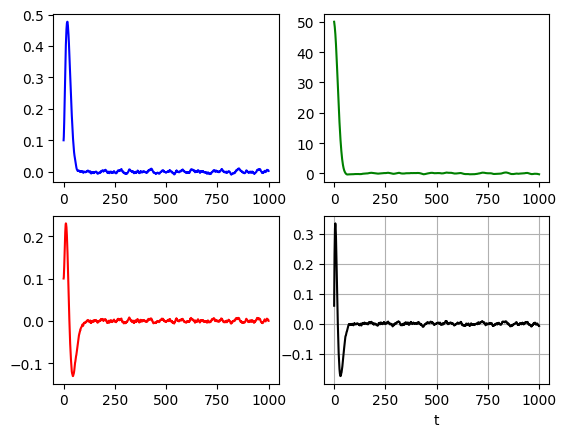

(1000,)


In [13]:
# Simulate System 
# Initial conditions
x0 = np.array([0.1,50,0.1,0.06]).reshape((4,1))  # initial displacement and velocity
x = x0
# Time vector
n = 1000  # start, stop, number of samples
A = Adis
B = np.ones((4,1))
q = 0.001
Q = np.inner(B,q*q*B)
F = np.random.normal(loc=0.0, scale=q, size=n)
for i in range(n-1):
    s1 = np.matmul(A,x0)
    s2 = F[i]*B
    x0 = np.add(s1,s2)
    x  = np.hstack((x,x0))

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2)
axs[0,0].plot(x[0, :], 'b', label='theta(t)')
axs[0,1].plot(x[1, :], 'g', label='V(t)')
axs[1,0].plot(x[2, :], 'r', label='alpha(t)')
axs[1,1].plot(x[3, :], 'k', label='q(t)')
# plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()
print(F.shape)

In [14]:
C.shape

(4, 4)

In [15]:
#THE SYSTEM
# After LQG controller design, the closed loop A is
Acl = np.array([[0.0,0.0,0.0,1.0],
               [-31.0566,-0.0265269,-2.66791,-0.659544],
               [-0.0288024,0.000119201,-0.77989,0.913012],
               [-2.34078,0.0304863,-0.279759,-2.32854]])

A = Acl
B = np.zeros((4,1))
C = np.eye(4)
D = np.zeros((4,1))
#C = np.zeros((1,4))
#C[0,0] = 1.0
#C[0,2] = -1.0
#D = np.zeros((1,1))
l_system = lti(A, B, C, D)

# method in ['zoh', 'bilinear', 'euler', 'backward_diff', 'foh', 'impulse']:
dt = 0.1
d_system = cont2discrete((A, B, C, D), dt, method='zoh')

Adis = d_system[0]
Cdis = d_system[2]
A = Adis
B = np.ones((4,1))
q = 0.001
Q = np.inner(B,q*q*B)
rsig = 0.1
R = rsig*rsig*np.eye(4)
#R = np.diag([rsig**2])
#END SYSTEM

Delta = np.array([[0.0,0.0],[0.0,0.0]])
M = A, C, Q, R
Mstar = A, C, Q, R
print(EIG_inf(M))
print(EGIG_inf(M,Mstar))

3.8140989467822344
3.8140989467815816


In [16]:
nstep1 = 51
nstep2 = 51
d1 = np.linspace(-1,1,nstep1)
d2 = np.linspace(-1,1,nstep2)

infodat = np.zeros((nstep1,nstep2,2))
for inc in range(0,nstep1):
    for jnc in range(0,nstep2):
        #THE SYSTEM
        # After LQG controller design, the closed loop A is
        Acl = np.array([[0.0,0.0,0.0,1.0],
                       [-31.0566,-0.0265269,-2.66791,-0.659544],
                       [-0.0288024,0.000119201,-0.77989,0.913012],
                       [-2.34078,0.0304863,-0.279759,-2.32854]])

        A = Acl
        B = np.zeros((4,1))
        C = np.zeros((5,4))
        C[0,0] = 1.0
        C[1,1] = 1.0
        C[2,2] = 1.0
        C[3,3] = 1.0
        C[4,0] = d1[inc]
        C[4,2] = d2[jnc]
        C[4,3] = np.sqrt(np.abs(1.0 - d1[inc]**2 - d2[jnc]**2))
        D = np.zeros((5,1))
        l_system = lti(A, B, C, D)

        # method in ['zoh', 'bilinear', 'euler', 'backward_diff', 'foh', 'impulse']:
        dt = 0.1
        d_system = cont2discrete((A, B, C, D), dt, method='zoh')

        Adis = d_system[0]
        Cdis = d_system[2]
        A = Adis
        B = np.ones((4,1))
        q = 0.001
        Q = np.inner(B,q*q*B)
        rsig = 0.01
        #R = rsig*rsig*np.eye(4)
        R = np.diag([rsig**2,100*rsig**2,rsig**2,rsig**2,rsig**2])
        #END SYSTEM

        if d1[inc]**2 + d2[jnc]**2 + np.abs(1.0 - d1[inc]**2 - d2[jnc]**2) <= 1.0:
            
            M = A, C, Q, R
            infodat[inc,jnc,0] = EIG_inf(M)
            EGIGpert = np.zeros(np.shape(A))
            for ix in range(0,4):
                for jx in range(0,4):
                    pert = 0.001
                    Delta = np.zeros(np.shape(A))
                    Delta[ix,jx] = A[ix,jx]
                    Mstar = A+pert*Delta, C, Q, R
                    EGIGpert[ix,jx] = (EGIG_inf(M,Mstar)-infodat[inc,jnc,0])/(pert)
            infodat[inc,jnc,1] = np.linalg.norm(EGIGpert[ix,jx])
        else:
            infodat[inc,jnc,0] = np.NaN
            infodat[inc,jnc,1] = np.NaN

In [17]:
foo = np.reshape(infodat,(-1,2))
foobar = np.copy(foo)
foobar[:,0] = -foobar[:,0]

In [18]:
def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    is_efficient[np.isnan(costs[:,0])] = False
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

boopareto = is_pareto_efficient_simple(foobar)

In [19]:
paretoidxs = np.unravel_index(boopareto.nonzero(), infodat[:,:,1].shape)

dparteo = np.zeros(((paretoidxs[0]).size,2))
for idx in range(0,(paretoidxs[0]).size):
    dparteo[idx,0] = d1[paretoidxs[0][0,idx]]
    dparteo[idx,1] = d2[paretoidxs[1][0,idx]]
    
idxeig = np.unravel_index(np.nanargmax(infodat[:,:,0]), infodat[:,:,1].shape)
idxegig = np.unravel_index(np.nanargmin(infodat[:,:,1]), infodat[:,:,1].shape)

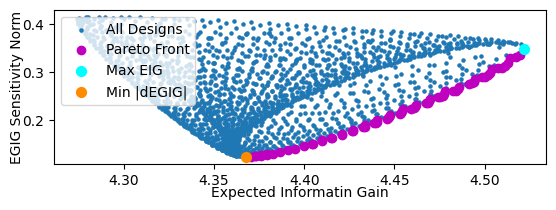

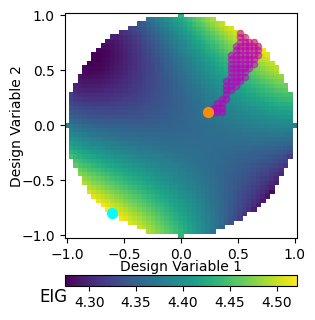

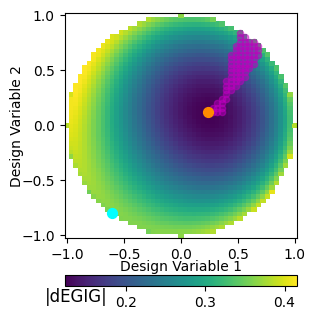

In [105]:
fig, ax = plt.subplots(figsize=(6.35,2))
ax.scatter(infodat[:,:,0], infodat[:,:,1],5)
ax.scatter(-foobar[boopareto,0],foobar[boopareto,1],color='m')
ax.scatter(infodat[idxeig[0],idxeig[1],0], infodat[idxeig[0],idxeig[1],1],50,color='cyan')
ax.scatter(infodat[idxegig[0],idxegig[1],0], infodat[idxegig[0],idxegig[1],1],50,color='darkorange')
ax.set_xlabel('Expected Informatin Gain',labelpad=-1)
ax.set_ylabel('EGIG Sensitivity Norm',labelpad=-1)
ax.legend(['All Designs', 'Pareto Front','Max EIG','Min |dEGIG|'],loc=2)
plt.show()

plt.subplots(figsize=(3,4))
plt.pcolor(d1,d2,infodat[:,:,0])
plt.colorbar(location='bottom',pad=0.12).ax.set_title('EIG',y=-2,x=-0.05)
plt.scatter(dparteo[:,1],dparteo[:,0],20,color='m',alpha=0.5)
plt.scatter(d1[idxeig[1]], d2[idxeig[0]],50,color='cyan')
plt.scatter(d1[idxegig[1]], d2[idxegig[0]],50,color='darkorange')
plt.xlabel('Design Variable 1',labelpad=-1)
plt.ylabel('Design Variable 2',labelpad=-2)
plt.show()

plt.subplots(figsize=(3,4))
plt.pcolor(d1,d2,infodat[:,:,1])
plt.colorbar(location='bottom',pad=0.12).ax.set_title('|dEGIG|',y=-2,x=0.05)
plt.scatter(dparteo[:,1],dparteo[:,0],20,color='m',alpha=0.5)
plt.scatter(d1[idxeig[1]], d2[idxeig[0]],50,color='cyan')
plt.scatter(d1[idxegig[1]], d2[idxegig[0]],50,color='darkorange')
plt.xlabel('Design Variable 1',labelpad=-1)
plt.ylabel('Design Variable 2',labelpad=-2)
plt.show()

In [120]:
np.nanmin(infodat[:,:,1])

0.1230046846814048

In [122]:
np.nanmax(infodat[:,:,1])

0.4157951451659869

In [89]:
# Kalman Filter for the F-16 stabilized Discrete time model
# True measurements
rsig = 1
y0 = np.add(x[0, :],np.random.normal(loc=0.0, scale=rsig, size=n))
y1 = np.add(x[1, :],np.random.normal(loc=0.0, scale=rsig, size=n))
y2 = np.add(x[2, :],np.random.normal(loc=0.0, scale=rsig, size=n))
y3 = np.add(x[3, :],np.random.normal(loc=0.0, scale=rsig, size=n))
y = np.array([[y0],[y1],[y2],[y3]]).reshape((4,n))
print(y.shape)
R = rsig*rsig*np.eye(4)  # measurement noise 

# Define the initial state and covariance matrix
x0 = np.array([0.15,20,0.6,0.6]).reshape((4,1))# initial state estimate
P0 = np.eye(4)  # initial covariance estimate

# Kalman filter algorithm
mu = x0  # initial state estimate
P = P0  # initial covariance estimate
x_kf = x0



(4, 1000)


In [90]:

for i in range(n-1):
    # Predict step
    mu_pred = np.matmul(A,mu)  # predict the next state
    P_pred = np.add(np.matmul(A,np.matmul(P,np.transpose(A))), Q)  # predict the next covariance
    # Update step
    y_pred = np.matmul(C,mu_pred)  # predict the measurement
    S = np.add(np.matmul(C,np.matmul(P_pred,np.transpose(C))),R)
    S_inv = jnp.linalg.solve(S,np.eye(4))
    K = np.matmul(np.matmul(P_pred,np.transpose(C)),S_inv) # calculate the Kalman gain
    # print(y[:,i])
    res = np.subtract(y[:,i],y_pred)
    mu = np.add(mu_pred,np.matmul(K,res))  # update the state estimate
    P = np.matmul(np.subtract(np.eye(4),np.matmul(K,C)),P_pred)  # update the covariance estimate
    x_kf  = np.hstack((x_kf,mu))
    # print(f"Time step {i}: x = {mu.ravel()}")


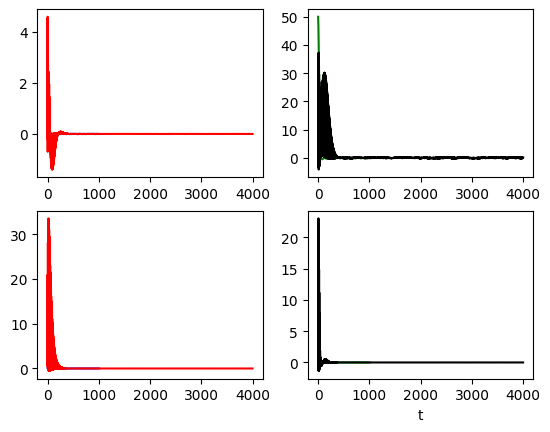

In [91]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2)
axs[0,0].plot(x[0, :], 'b', label='x(t)')
axs[0,1].plot(x[1, :], 'g', label='v(t)')
axs[1,0].plot(x[2, :], 'b', label='x(t)')
axs[1,1].plot(x[3, :], 'g', label='v(t)')
axs[0,0].plot(x_kf[0, :], 'r', label='x_kf(t)')
axs[0,1].plot(x_kf[1, :], 'k', label='v_kf(t)')
axs[1,0].plot(x_kf[2, :], 'r', label='x_kf(t)')
axs[1,1].plot(x_kf[3, :], 'k', label='v_kf(t)')
# plt.legend(loc='best')
plt.xlabel('t')
# plt.grid()
plt.show()
# print(F.shape)

In [92]:
# EGIG Calculations for F16
Delta = np.array([0.1,0.01]).reshape((1,2))
Delta_egig = np.array([0.1,0.01]).reshape((1,2))
Delta_eig = jnp.zeros((1,2))
egig_del_val = np.zeros(n-1)
eig_del_val = np.zeros(n-1)
eig_val = np.zeros(n-1)
etil_del = np.zeros(n-1)


# Kalman filter algorithm
mu = x0  # initial state estimate
P = P0  # initial covariance estimate
mu_prior = mu
P_prior = P
# mu_prior_Cdel = mu
# P_prior_Cdel = P
mu_post_Cdel = mu
P_post_Cdel = P
mu_post_C = mu
P_post_C = P
Cdel = np.add(C,Delta)

for i in range(n-1):
    # EGIG with Delta.
    # The reference posterior distribution is with the correct C
    # The calculated posterior distribution is with the  C + Delta
    # The prior distribution is just the update with no C

    # prior distribution
    mu_prior = np.matmul(A,mu_prior)  # predict the next state
    P_prior = np.add(np.matmul(A,np.matmul(P_prior,np.transpose(A))), Q)  # predict the next covariance

    # posterior distribution with C + Delta
    # Predict step
    mu_pred_Cdel = np.matmul(A,mu_post_Cdel)  # predict the next state
    P_pred_Cdel = np.add(np.matmul(A,np.matmul(P_post_Cdel,np.transpose(A))), Q)  # predict the next covariance
    # Update step
    y_pred_Cdel = np.matmul(Cdel,mu_pred_Cdel)  # predict the measurement
    S_Cdel = np.add(np.matmul(Cdel,np.matmul(P_pred_Cdel,np.transpose(Cdel))),R)
    K_Cdel = np.matmul(np.matmul(P_pred_Cdel,np.transpose(Cdel)),(1/S_Cdel)) # calculate the Kalman gain
    res_Cdel = np.subtract(y[i],y_pred_Cdel)
    mu_post_Cdel  = np.add(mu_pred_Cdel,np.matmul(K_Cdel,res_Cdel))  # update the state estimate
    P_post_Cdel  = np.matmul(np.subtract(np.eye(2),np.matmul(K_Cdel,Cdel)),P_pred_Cdel)  # update the covariance estimate
    x_kf_Cdel  = np.hstack((x_kf_Cdel,mu_post_Cdel))
    
    # posterior distribution with C
    # Predict step
    mu_pred_C = np.matmul(A,mu_post_C)  # predict the next state
    P_pred_C = np.add(np.matmul(A,np.matmul(P_post_C,np.transpose(A))), Q)  # predict the next covariance
    # Update step
    y_pred_C = np.matmul(C,mu_pred_C)  # predict the measurement
    S_C = np.add(np.matmul(C,np.matmul(P_pred_C,np.transpose(C))),R)
    K_C = np.matmul(np.matmul(P_pred_C,np.transpose(C)),(1/S_C)) # calculate the Kalman gain
    res_C = np.subtract(y[i],y_pred_C)
    mu_post_C  = np.add(mu_pred_C,np.matmul(K_C,res_C))  # update the state estimate
    P_post_C  = np.matmul(np.subtract(np.eye(2),np.matmul(K_C,C)),P_pred_C)  # update the covariance estimate
    x_kf_C  = np.hstack((x_kf_C,mu_post_C))

    # Need to careful here
    # The C+Delta system evolves seperately than C system
    eig_del_val[i] = EGIG(P_pred_Cdel, C, Delta, R)
    egig_del_val[i] = EGIG(P_prior, C, Delta_egig, R)



    egig_del_val[i] = EGIG(P_pred, C, Delta_egig, R)
    eig_val[i] = EGIG(P_pred, C, Delta_eig, R)
    etil_del[i] = ETIL_Delta(P_pred, H, Delta, R)
    # print(f"Time step {i}: x = {mu.ravel()}")

ValueError: operands could not be broadcast together with shapes (4,4) (1,2) 